
<h1><span style="background-color: #bfedd2;">House Prices - Advanced Regression Techniques</span></h1>

<p><strong>Goal:&nbsp;</strong>&nbsp;It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable</p>

In [1]:
#Librerias para poder correr el Notebook
!pip uninstall -y scikit-learn scikeras tensorflow keras
!pip install scikit-learn==1.5.2 scikeras==0.13.0 tensorflow==2.18.0 keras==3.10.0
!pip install optuna

Found existing installation: scikit-learn 1.2.2
Uninstalling scikit-learn-1.2.2:
  Successfully uninstalled scikit-learn-1.2.2
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: keras 3.8.0
Uninstalling keras-3.8.0:
  Successfully uninstalled keras-3.8.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 81.8 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 33.4 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.


### Imports

In [61]:
import pandas as pd
import numpy as np
import optuna
import optuna.visualization as vis
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.metrics import make_scorer, mean_squared_error
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import joblib
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [62]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


### Eliminar Mensaje de Warnings

In [63]:
import warnings
warnings.filterwarnings("ignore", message="Do not pass an `input_shape`/`input_dim` argument to a layer.*")

## 1. Lectura del conjunto de datos

In [65]:
#  CARGA Y PREPROCESAMIENTO
df = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

## 2. Visualización del conjunto de datos

In [74]:
#Visualizacion de los datos de entrenamiento
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [75]:
# Comprobamos si alguna columna tiene valores nulos
df.isna().sum()[df.isna().sum() > 0]

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

## 3. Preparación del conjunto de datos

In [76]:
# Eliminar columnas con muchos nulos
threshold = 0.46
cols_to_drop = df.isnull().mean()[lambda x: x > threshold].index
df.drop(columns=cols_to_drop, inplace=True)

In [77]:
#Verificamos si fueron eliminadas las columnas correctamente.
df.isna().sum()[df.isna().sum() > 0]

LotFrontage     259
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

In [78]:
#Separacion de X y Y
y = df['SalePrice']
X = df.drop(['SalePrice', 'Id'], axis=1)

In [79]:
# Pipelines de preprocesamiento - Se sustituye en las columnas numericas  por la mediana
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Se imputan variables categoricas con la moda y se convierten a columnas categoricas a numericas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])
# ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=['int64', 'float64'])),
    ('cat', cat_pipeline, make_column_selector(dtype_include='object'))
])

In [80]:
# Separamos una parte en prueba 20% y entrenamiento 89%

X_train, X_test, y_train, y_test = train_test_split(
    X, y,                # tus datos
    test_size=0.2,       # 20% para test
    random_state=42,     # para reproducibilidad
    shuffle=True         # mezcla aleatoria de los datos
)

In [81]:
#Aplicamos el preprocesamiento en Xtrain para poder hacer Validacion Cruzada
X_processed = preprocessor.fit_transform(X_train)
X_test_processed= preprocessor.fit_transform(X_test)
input_dim = X_processed.shape[1]
input_dim

264

## 4.- Redes Neuronales Multicapa

In [82]:
# Construir modelo inicial
def build_first_model():
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(X_processed.shape[1],)))
    #model.add(BatchNormalization())
    model.add(Dropout(.1))

    model.add(Dense(32, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(.1))

    model.add(Dense(16, activation='relu'))
    #model.add(BatchNormalization())
    model.add(Dropout(.1))

    model.add(Dense(1))  # Output layer sin activación (regresión)


    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [83]:
# Early stopping para el entrenamiento 
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Regresor con los mejores parámetros
primer_regressor = KerasRegressor(
     model=build_first_model,
    epochs=50,
    batch_size=16,
    verbose=1,
    validation_split=0.2,
     callbacks=[early_stop],
)

In [84]:
# Crear el pipeline final (reutilizamos `preprocessor` ya definido)
primer_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ("keras_reg", primer_regressor)
  ])

# Entrenar con TODOS los datos
primer_pipeline.fit(X_train, y_train)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 37658259456.0000 - mae: 178451.5625 - val_loss: 37750947840.0000 - val_mae: 180860.7812
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 40290287616.0000 - mae: 182196.4375 - val_loss: 36965335040.0000 - val_mae: 178729.6875
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 37248020480.0000 - mae: 177221.3594 - val_loss: 32792059904.0000 - val_mae: 166061.1250
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 33085083648.0000 - mae: 162956.1875 - val_loss: 25307459584.0000 - val_mae: 137372.6406
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27247505408.0000 - mae: 141702.5625 - val_loss: 22285938688.0000 - val_mae: 126019.8438
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22836924416.0000 - mae: 127200.4922 - val_loss: 19270404096.0000 - val_mae: 114973.8906
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 20163897344.0000 - mae: 116619.4219 - val_loss: 16287267840.0000 

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ef54bed93d0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ef54bedb9d0>)])),
                ('keras_reg',
                 KerasRegressor(batch_size=16, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ef54be5aad0>], epochs=50, model=<function build_first_model at 0x7ef54be0f7e0>, validation_split=0.2))])

In [85]:
# Predicción y métricas
y_pred = primer_pipeline.predict(X_test)
print("R2:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred))

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R2: 0.8263700604438782
RMSE: 36493.812639736934
MAE: 20606.429724288315


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



## 5.- Optimizar Modelo RNA

In [86]:
#  FUNCIÓN OBJETIVO OPTUNA 

def objective(trial):
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    dropout1 = trial.suggest_float("dropout1", 0.0, 0.5)
    dropout2 = trial.suggest_float("dropout2", 0.0, 0.5)
    dropout3 = trial.suggest_float("dropout3", 0.0, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)

    # Número de capas activas
    n_layers = trial.suggest_int("n_layers", 1, 3)

    # Definir unidades para cada capa según su posición y rango
    units1 = trial.suggest_int('units1', 16, 128, step=8)
    units2 = trial.suggest_int('units2', 8, 64, step=8)
    units3 = trial.suggest_int('units3', 8, 64, step=4)

    def build_model(input_dim):
        model = Sequential()
        model.add(Dense(units1, activation=activation, input_shape=(input_dim,)))
        #model.add(BatchNormalization())
        model.add(Dropout(dropout1))

        if n_layers >= 2:
            model.add(Dense(units2, activation=activation))
           # model.add(BatchNormalization())
            model.add(Dropout(dropout2))

        if n_layers >= 3:
            model.add(Dense(units3, activation=activation))
           # model.add(BatchNormalization())
            model.add(Dropout(dropout3))

        model.add(Dense(1))  # salida de regresión
        model.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        return model

    regressor = KerasRegressor(
        model=build_model,
        model__input_dim=input_dim,
        epochs=10,
        batch_size=8,
        verbose=0,
        validation_split=0.2,
        callbacks=[EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)]
    )

    pipeline = Pipeline([
        ('model', regressor)
    ])

    # Validación cruzada
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_processed, y_train,
                             scoring=make_scorer(mean_squared_error, greater_is_better=False),
                             cv=kf)

    return -np.mean(scores)  # Optuna minimiza → invertimos el error

In [87]:
#  OPTIMIZACIÓN MEDIANTE OPTUNA

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

print(" Mejores hiperparámetros encontrados:")
for k, v in study.best_params.items():
    print(f"{k}: {v}")

[I 2025-06-05 18:10:01,136] A new study created in memory with name: no-name-3a733ac0-fd94-4c8d-8877-c1ae3c132041
[I 2025-06-05 18:10:22,408] Trial 0 finished with value: 29206140271.081066 and parameters: {'activation': 'relu', 'dropout1': 0.1850015557473058, 'dropout2': 0.4543414769329965, 'dropout3': 0.359932708551747, 'lr': 0.0005022167036094157, 'n_layers': 2, 'units1': 104, 'units2': 48, 'units3': 56}. Best is trial 0 with value: 29206140271.081066.
[I 2025-06-05 18:10:44,727] Trial 1 finished with value: 38882905921.9049 and parameters: {'activation': 'tanh', 'dropout1': 0.16897219885247955, 'dropout2': 0.4391005711224668, 'dropout3': 0.3056758323337543, 'lr': 0.0004624039804833879, 'n_layers': 2, 'units1': 112, 'units2': 8, 'units3': 32}. Best is trial 0 with value: 29206140271.081066.
[I 2025-06-05 18:11:03,531] Trial 2 finished with value: 38884064225.8002 and parameters: {'activation': 'tanh', 'dropout1': 0.08366583934039767, 'dropout2': 0.011970501882381024, 'dropout3': 0.2

 Mejores hiperparámetros encontrados:
activation: relu
dropout1: 0.3957775671910239
dropout2: 0.13157718773571714
dropout3: 0.08102319699530519
lr: 0.0035036343485671637
n_layers: 2
units1: 112
units2: 64
units3: 24


In [88]:
# Recuperar los mejores hiperparámetros
best_params = study.best_params

In [89]:
# Curva de convergencia
vis.plot_optimization_history(study)

### Elegir el Mejor Modelo obtenido con Optuna

In [90]:
# Construir modelo con los mejores parámetros
def build_best_model():
    model = Sequential()
    model.add(Dense(best_params['units1'], activation=best_params['activation'], input_shape=(input_dim,)))
    #model.add(BatchNormalization())
    model.add(Dropout(best_params['dropout1']))

    model.add(Dense(best_params['units2'], activation=best_params['activation']))
    #model.add(BatchNormalization())
    model.add(Dropout(best_params['dropout2']))

    #model.add(Dense(best_params['units3'], activation=best_params['activation']))
    #model.add(BatchNormalization())
   # model.add(Dropout(best_params['dropout3']))

    model.add(Dense(1))  # Output layer sin activación (regresión)

    optimizer = Adam(learning_rate=best_params['lr'])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

In [91]:
# Early stopping para el entrenamiento final
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Regresor con los mejores parámetros
best_regressor = KerasRegressor(
    model=build_best_model,
    epochs=200,
    batch_size=16,
    verbose=0,
    validation_split=0.2,
    callbacks=[early_stop]
)

In [92]:
modelo = build_best_model()
modelo.summary()

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_371 (Dense)                    │ (None, 112)                 │          29,680 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_247 (Dropout)                │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_372 (Dense)                    │ (None, 64)                  │           7,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_248 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_373 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,977 (144.44 KB)

 Trainable params: 36,977 (144.44 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# Crear el pipeline final (reutilizamos `preprocessor` ya definido)
final_pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ("keras_reg", best_regressor)
])

In [94]:
# Entrenar con TODOS los datos
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ef54bed93d0>),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7ef54bedb9d0>)])),
                ('keras_reg',
                 KerasRegressor(batch_size=16, callbacks=[<keras.src.callbacks.early_stopping.EarlyStopping object at 0x7ef5259349d0>], epochs=200, model=<function build_best_model at 0x7ef52e586480>, validation_split=0.2, verbose=0))])

In [95]:
#Predicciones
y_pred = final_pipeline.predict(X_test)

### Evaluación de Resultados

In [96]:
# Evaluar
print("R2:", r2_score(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("MAE:", mean_absolute_error(y_test, y_pred))

R2: 0.8536895513534546
RMSE: 33499.98217621672
MAE: 19388.38986916738


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



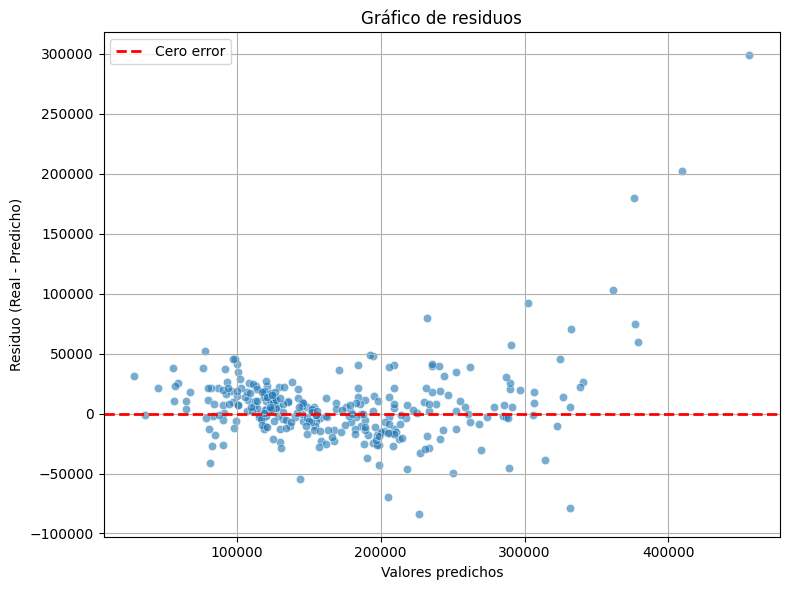

In [97]:
#Analisis de Residuos

# Calcular residuos
residuos = y_test - y_pred
# Gráfico de residuos
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuos, alpha=0.6)
plt.axhline(0, color='red', linestyle='--', lw=2, label='Cero error')
plt.xlabel('Valores predichos')
plt.ylabel('Residuo (Real - Predicho)')
plt.title('Gráfico de residuos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

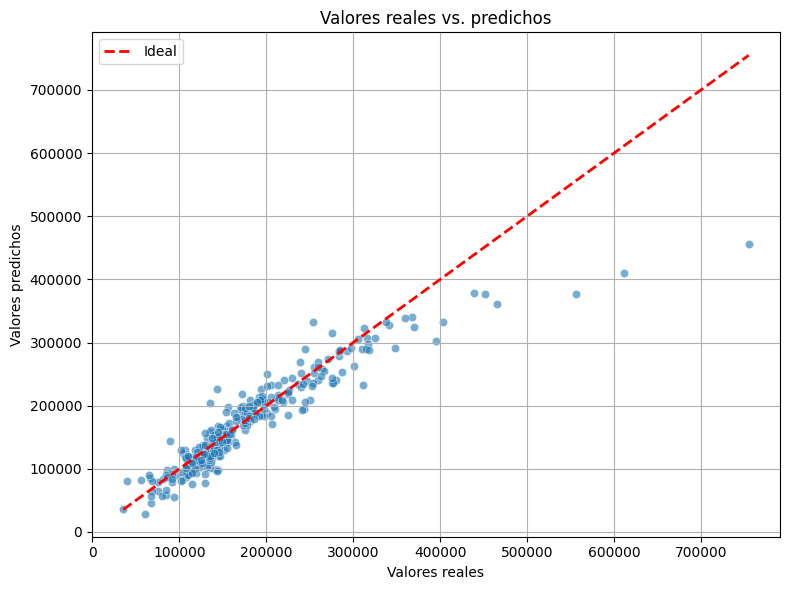

In [98]:
#Grafico de Analisis de predichos y valores reales

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Ideal')
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Valores reales vs. predichos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



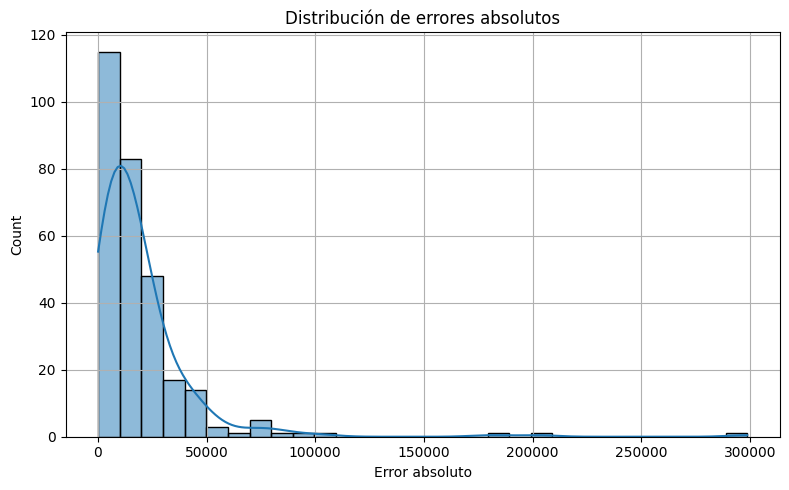

In [99]:
#Grafico de Distribucion de Errores Absolutos
errores = np.abs(y_test - y_pred)

plt.figure(figsize=(8, 5))
sns.histplot(errores, bins=30, kde=True)
plt.xlabel('Error absoluto')
plt.title('Distribución de errores absolutos')
plt.grid(True)
plt.tight_layout()
plt.show()

## 6.-Guardar Modelo Para Uso Posterior

In [100]:
# Guardar modelo entrenado
# O guardarlas junto con el modelo usando joblib (más recomendable)
joblib.dump({
    'modelo': final_pipeline,
    'columnas_eliminadas': list(cols_to_drop),
    'mejores_parametros': best_params
}, 'modelo_final_optuna.pkl')

print("✅ Modelo final entrenado y guardado con éxito.")

✅ Modelo final entrenado y guardado con éxito.


In [101]:
# Cargar modelo y columnas eliminadas
data = joblib.load('modelo_final_optuna.pkl')
modelo = data['modelo']
cols_eliminadas = data['columnas_eliminadas']

In [102]:
# Cargar test
df_test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
X_test = df_test.drop(['Id'], axis=1)
X_test = X_test.drop(columns=cols_eliminadas, errors='ignore')

In [103]:
# Predecir con el conjunto de prueba
y_pred = modelo.predict(X_test)

In [104]:
# Exportar para Kaggle
submission = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': y_pred
})
submission.to_csv("submission.csv", index=False)

In [105]:
# Verificar que sea el formato que desea Kaggle
submission.head(5)

,Id,SalePrice
0,1461,104473.445312
1,1462,302841.625000
2,1463,185165.640625
3,1464,211152.390625
4,1465,179632.796875
